## Recupération des news


In [10]:
#!pip install wordcloud
#!pip install nltk

     |████████████████████████████████| 1.5 MB 2.0 MB/s            
     |████████████████████████████████| 763 kB 49.1 MB/s            


In [11]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


#partie wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib


# partie NLP
import nltk

nltk.download('punkt')
words = nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


In [12]:
def get_company():

    url = 'https://www.investing.com/equities'
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    tbody = soup.findAll("td",{"class":"bold left noWrap elp plusIconTd"})
    l = []
    for p in tbody:
        l.append(p.find("a")['href'].split('/')[2])
    return l

In [13]:
liste_entreprise = get_company()
liste_entreprise

['boeing-co',
 'chevron',
 'caterpillar',
 'intel-corp',
 'microsoft-corp',
 'disney',
 'cisco-sys-inc',
 'goldman-sachs-group',
 'jp-morgan-chase',
 'coca-cola-co',
 'mcdonalds',
 'merck---co',
 '3m-co',
 'apple-computer-inc',
 'amazon-com-inc',
 'amgen-inc',
 'wal-mart-stores',
 'home-depot',
 'ibm',
 'verizon-communications',
 'johnson-johnson',
 'honeywell-intl',
 'salesforce-com',
 'visa-inc',
 'united-health-group',
 'nike',
 'procter-gamble',
 'tesla-motors',
 'facebook-inc',
 'google-inc-c']

In [14]:
def get_news(company,nb_page=1):
    url = 'https://www.investing.com/equities/'+company+'-news/'+str(nb_page)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("a",{"class":"title"})
    #print(article_body)
    l=[]
    for p in article_body:
        l.append(p.get("title"))
    return l[6:]

In [15]:
print(get_news("tesla-motors",3))

["U.S. Inflation, Weak U.K. Growth, Russia/Ukraine Dispute   - What's Moving Markets", 'Tesla sued by second female worker over sexual harassment, retaliation', "Factbox-Tesla's Musk sells shares worth nearly $12 billion in a month", 'Musk sells Tesla shares worth $963.2 million - filings', 'Wall St closes lower ahead of inflation data, Fed meeting', 'U.S. safety agency discussing Tesla camera replacements', 'U.S. stocks lower at close of trade; Dow Jones Industrial Average down 0.00%', 'Apple inches closer to $3 trillion market cap', 'Ford caps F-150 Lightning orders at 200,000 - CEO Farley', 'Ethereum transaction energy use equals 2.5 miles in a Tesla Model 3: Report ']


In [16]:
def get_tilte_dictionary(company_list, number_page=1):
    dicto = {}
    for company in company_list :
        l = []
        for page in range(1,number_page+1):
            l = l + get_news(company, page)
        dicto[str(company)] = ' '.join(l).lower()
    
    return dicto


## Word cloud version simple

Peut-être essayer de faire un truc qui cherche le masque automatiquement à partir du nom de l'entreprise si on le sent

In [17]:
data = get_tilte_dictionary(liste_entreprise[:2],1)

In [18]:
print(data['boeing-co'])

u.s. stocks higher at close of trade; dow jones industrial average up 0.60% finland orders 64 lockheed f-35 fighter jets for $9.4 billion china's domestic air traffic recovery faltering due to zero-covid policy jim cramer says he's sticking with boeing, believes long-term prospects remain bright veteran boeing airplanes executive mark jenks to retire u.s. stocks lower at close of trade; dow jones industrial average down 0.00% jetpacks, flying cars and taxi drones: transport's future is in the skies veteran boeing airplanes executive mark jenks to retire american airlines plans to reduce international flights next summer stocks making the biggest moves midday: cvs, lucid, southwest airlines, boeing, gamestop and more


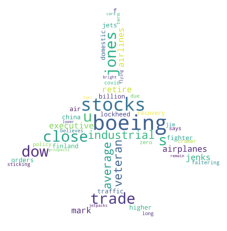

In [19]:
mask = np.array(Image.open(requests.get('https://www.freeiconspng.com/uploads/airplane-icon-image-gallery-1.png', stream=True).raw))

wordcloud = WordCloud(background_color = 'white', max_words = 50, mask  = mask).generate(data[liste_entreprise[0]])
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# NLP

## Tokenization

In [20]:
words = nltk.word_tokenize(data[liste_entreprise[0]])
#print(words)

## suppression de la ponctuation


In [21]:
words = [word for word in words if word.isalpha()] #cela retire le mot u.s,  on peux supposer que cela n'a pas beaucoup d'impact puisque nous travaillons uniquement sur des données des u.s
#print(words)

## retirer les stop word

In [22]:
stop_words = set(stopwords.words('english'))
keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
stop_words = [word for word in stop_words if word not in keep_words]
words = [ word for word in words if not word in stop_words]
#print(words)
#print(stopwords)

## stemming

In [23]:
stemmer = SnowballStemmer(language = 'english')
stemmed = [stemmer.stem(word) for word in words]
#print(stemmed)

## Fonction qui transforme les données d'un seul coup:

In [24]:
def clean_text(text):
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
    stop_words = [word for word in stop_words if word not in keep_words]
    words = [ word for word in words if not word in stop_words]
    
    stemmer = SnowballStemmer(language = 'english')
    stemmed = [stemmer.stem(word) for word in words]
    
    return(' '.join(stemmed))

In [31]:
def return_sentiment(company_data):
    text = clean_text(company_data)
    sid = SentimentIntensityAnalyzer()
    l = sid.polarity_scores(clean_text(company_data))
    return(l['pos']*1.5 + l['neu'] - l['neg']*1.5) #fonction faites à la main,à discuter

In [26]:
def build_data_sentiment(company_list, page=1):
    data = get_tilte_dictionary(company_list, page)
    df = pd.DataFrame(columns = ['company','score'])
    for company in company_list : 
        df = df.append({'company': str(company), 'score':return_sentiment(data[company])},ignore_index=True)
    return df

In [28]:
df = build_data_sentiment(liste_entreprise[:5],3) #surment un peu long pour le dataframe complet !!!

In [29]:
df = df.set_index('company')
ordered_df = df['score'].sort_values(ascending = False)

In [30]:
kept_company = ordered_df[:2]
print(kept_company)

company
microsoft-corp    0.9205
caterpillar       0.9035
Name: score, dtype: float64
